## 03 Machine Learning (Overall Sales Forecasting)
In this notebook the overal weekly sales in the next year is forecasted with time series method. <br>

https://www.datasciencesmachinelearning.com/2019/01/arimasarima-in-python.html

In [104]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import statsmodels.api as sm
from matplotlib.dates import MonthLocator, DateFormatter

In [105]:
df = pd.read_csv('./datasets/cleaned_training_data.csv')

In [106]:
df_test = pd.read_csv('./datasets/test.csv')

In [107]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115064 entries, 0 to 115063
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   Store      115064 non-null  int64 
 1   Dept       115064 non-null  int64 
 2   Date       115064 non-null  object
 3   IsHoliday  115064 non-null  bool  
dtypes: bool(1), int64(2), object(1)
memory usage: 2.7+ MB


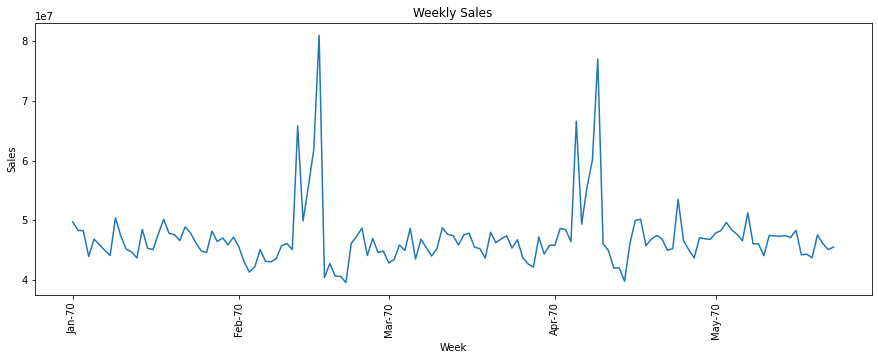

In [108]:
weekly_trend = df.groupby('Date')['Weekly_Sales'].sum()

fig, ax = plt.subplots(figsize=(15,5))

ax.plot(weekly_trend)

#defines the tick location 
ax.xaxis.set_major_locator(MonthLocator())
#defines the label format
ax.xaxis.set_major_formatter(DateFormatter("%b-%y"))
ax.tick_params(axis="x", labelrotation= 90)


plt.title("Weekly Sales")
plt.xlabel('Week') 
plt.ylabel('Sales') 
plt.show()

In [109]:
#Turn the data (total weekly sales) into a time series
ts = weekly_trend
ts.index = pd.to_datetime(ts.index)

In [110]:
ts = ts.to_frame()

In [111]:
ts_reduced = ts/1000000

In [112]:
ts_reduced

,Weekly_Sales
Date,
2010-02-05,49.750740
2010-02-12,48.336678
2010-02-19,48.276994
2010-02-26,43.968571
2010-03-05,46.871470
...,...
2012-09-28,43.734899
2012-10-05,47.566639
2012-10-12,46.128514


In [21]:
prediction_index = pd.to_datetime(df_test.groupby('Date')['Store'].sum().index)

In [22]:
prediction_index

DatetimeIndex(['2012-11-02', '2012-11-09', '2012-11-16', '2012-11-23',
               '2012-11-30', '2012-12-07', '2012-12-14', '2012-12-21',
               '2012-12-28', '2013-01-04', '2013-01-11', '2013-01-18',
               '2013-01-25', '2013-02-01', '2013-02-08', '2013-02-15',
               '2013-02-22', '2013-03-01', '2013-03-08', '2013-03-15',
               '2013-03-22', '2013-03-29', '2013-04-05', '2013-04-12',
               '2013-04-19', '2013-04-26', '2013-05-03', '2013-05-10',
               '2013-05-17', '2013-05-24', '2013-05-31', '2013-06-07',
               '2013-06-14', '2013-06-21', '2013-06-28', '2013-07-05',
               '2013-07-12', '2013-07-19', '2013-07-26'],
              dtype='datetime64[ns]', name='Date', freq=None)

# Decomposition

In [28]:
#STATIONARITY CHECK

from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    #rolmean = pd.rolling_mean(timeseries, window=12)
    rolmean = timeseries.rolling(window=12).mean()
    #rolstd = pd.rolling_std(timeseries, window=12)
    rolstd = timeseries.rolling(window=12).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

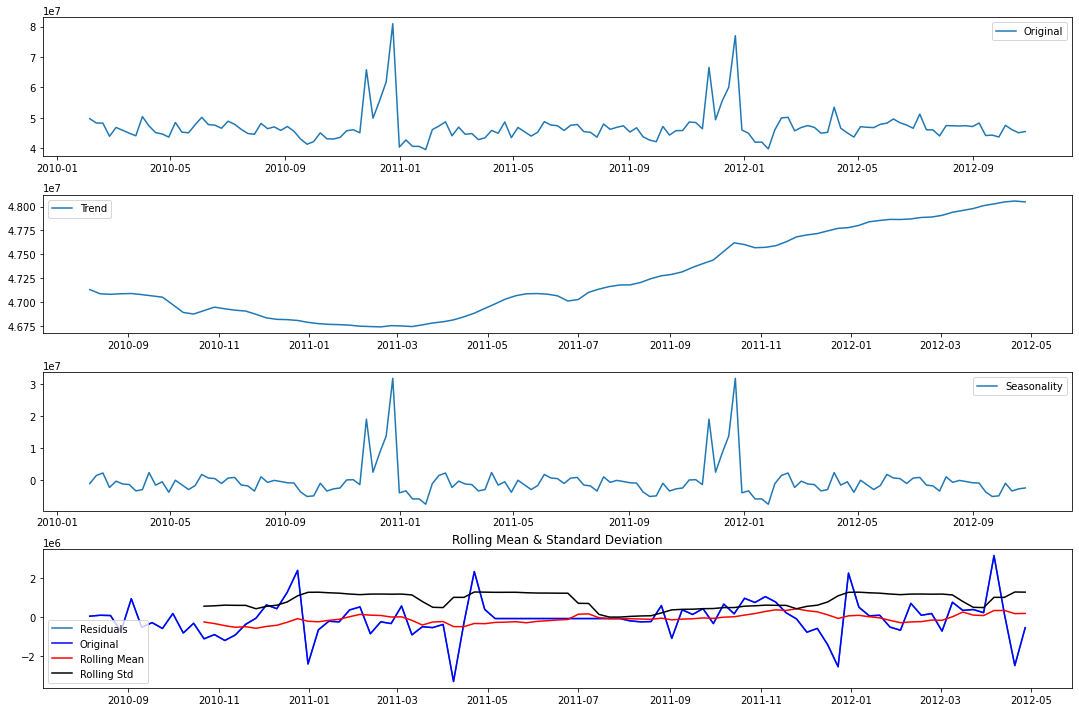

Results of Dickey-Fuller Test:
Test Statistic                -6.956922e+00
p-value                        9.377200e-10
#Lags Used                     1.000000e+00
Number of Observations Used    8.900000e+01
Critical Value (1%)           -3.506057e+00
Critical Value (5%)           -2.894607e+00
Critical Value (10%)          -2.584410e+00
dtype: float64


In [35]:
#DECOMPOSITION to see the different seasonal components
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

fig, ax = plt.subplots(figsize=(15,10))

plt.subplot(411)
plt.plot(ts, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

ts_decompose = residual
ts_decompose.dropna(inplace=True)
test_stationarity(ts_decompose)

## Test for stationarity

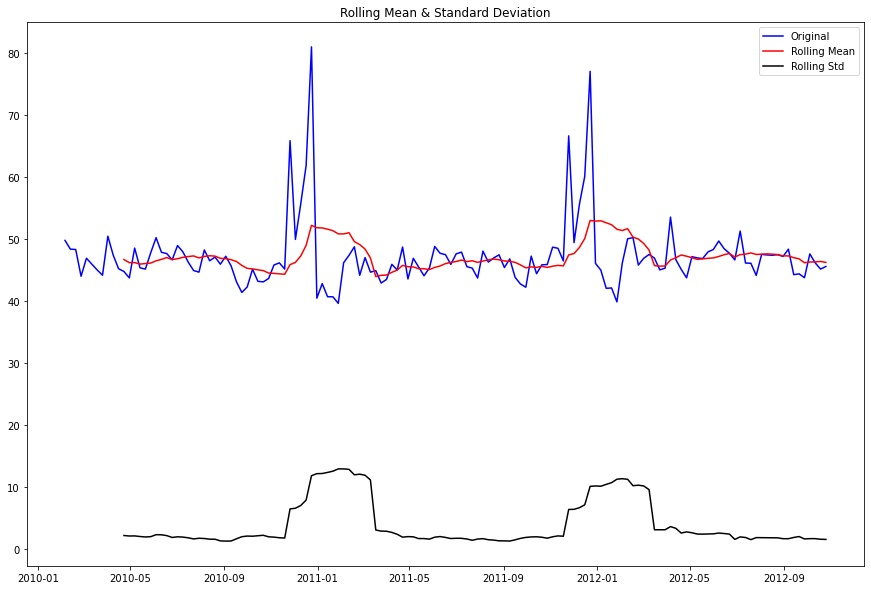

Results of Dickey-Fuller Test:
Test Statistic                -5.908298e+00
p-value                        2.675979e-07
#Lags Used                     4.000000e+00
Number of Observations Used    1.380000e+02
Critical Value (1%)           -3.478648e+00
Critical Value (5%)           -2.882722e+00
Critical Value (10%)          -2.578065e+00
dtype: float64


In [113]:
fig, ax = plt.subplots(figsize=(15,10))
test_stationarity(ts_reduced)

### p-value <0.05: it is stationary
Can use SARIMA

## ACF and PACF

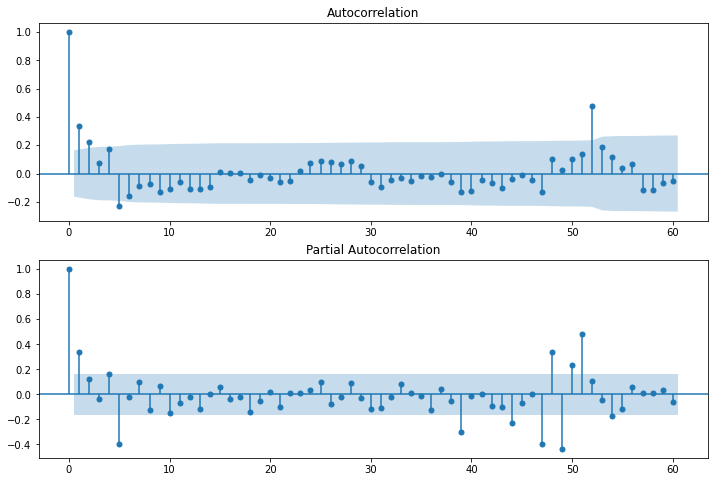

In [126]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(ts_reduced, lags=60, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(ts_reduced, lags=60, ax=ax2)

## values for ARIMA: p=1,  q = 1, d = 0

# Training and testing

In [138]:
from pmdarima.arima import auto_arima
model = auto_arima(ts_reduced, start_p=0, start_q=0,
                           max_p=1, max_q=2, m=52,
                           start_P=1, seasonal=True,
                           d=1, D=0, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,0,1)[52] intercept   : AIC=764.584, Time=0.84 sec
 ARIMA(0,1,0)(0,0,0)[52] intercept   : AIC=927.970, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[52] intercept   : AIC=inf, Time=0.56 sec
 ARIMA(0,1,1)(0,0,1)[52] intercept   : AIC=inf, Time=1.10 sec
 ARIMA(0,1,0)(0,0,0)[52]             : AIC=925.973, Time=0.01 sec
 ARIMA(0,1,0)(0,0,1)[52] intercept   : AIC=inf, Time=0.84 sec
 ARIMA(0,1,0)(1,0,0)[52] intercept   : AIC=inf, Time=0.46 sec
 ARIMA(0,1,0)(2,0,1)[52] intercept   : AIC=inf, Time=3.88 sec
 ARIMA(0,1,0)(1,0,2)[52] intercept   : AIC=inf, Time=3.41 sec
 ARIMA(0,1,0)(0,0,2)[52] intercept   : AIC=inf, Time=7.11 sec
 ARIMA(0,1,0)(2,0,0)[52] intercept   : AIC=inf, Time=3.32 sec
 ARIMA(0,1,0)(2,0,2)[52] intercept   : AIC=768.584, Time=4.13 sec
 ARIMA(1,1,0)(1,0,1)[52] intercept   : AIC=740.911, Time=1.26 sec
 ARIMA(1,1,0)(0,0,1)[52] intercept   : AIC=inf, Time=1.31 sec
 ARIMA(1,1,0)(2,0,1)[52] intercept   : AIC=inf, Time=5.52 sec
 ARIMA(

In [133]:
model = sm.tsa.statespace.SARIMAX(ts_reduced, order=(1, 0, 0), seasonal_order=(1, 0, 1, 52))

C:\Users\Thomas\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  warnings.warn('No frequency information was'
C:\Users\Thomas\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  warnings.warn('No frequency information was'


In [134]:
model_fit = model.fit()

C:\Users\Thomas\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


In [135]:
print(model_fit.summary())

                                      SARIMAX Results                                       
Dep. Variable:                         Weekly_Sales   No. Observations:                  143
Model:             SARIMAX(1, 0, 0)x(1, 0, [1], 52)   Log Likelihood                -380.694
Date:                              Sat, 19 Feb 2022   AIC                            769.388
Time:                                      01:04:18   BIC                            781.239
Sample:                                  02-05-2010   HQIC                           774.204
                                       - 10-26-2012                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9636      0.022     44.662      0.000       0.921       1.006
ar.S.L52       0.95

In [136]:
predictions = model_fit.forecast(39)
df_predictions = pd.Series(predictions,index = prediction_index)

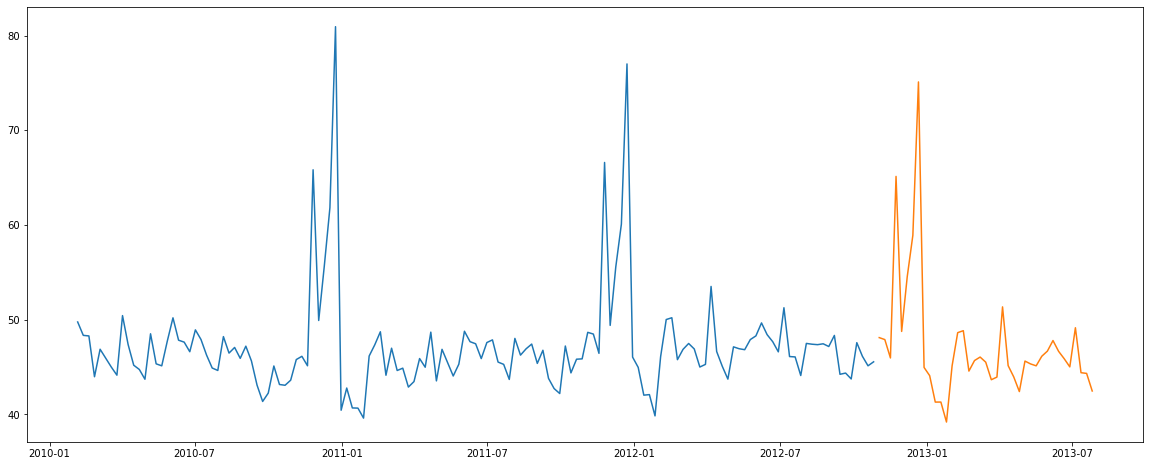

In [137]:
plt.figure(figsize=(20,8))

plt.plot(ts_reduced)
plt.plot(df_predictions)

In [78]:
df_predictions

Date
2012-11-02    4.822506e+07
2012-11-09    4.829480e+07
2012-11-16    4.703205e+07
2012-11-23    5.953351e+07
2012-11-30    4.886228e+07
2012-12-07    5.268954e+07
2012-12-14    5.549578e+07
2012-12-21    6.598620e+07
2012-12-28    4.678426e+07
2013-01-04    4.610967e+07
2013-01-11    4.429045e+07
2013-01-18    4.432607e+07
2013-01-25    4.293257e+07
2013-02-01    4.680949e+07
2013-02-08    4.924309e+07
2013-02-15    4.935918e+07
2013-02-22    4.661374e+07
2013-03-01    4.728926e+07
2013-03-08    4.767318e+07
2013-03-15    4.731375e+07
2013-03-22    4.613011e+07
2013-03-29    4.630291e+07
2013-04-05    5.140727e+07
2013-04-12    4.714366e+07
2013-04-19    4.617772e+07
2013-04-26    4.533647e+07
2013-05-03    4.744975e+07
2013-05-10    4.732643e+07
2013-05-17    4.726289e+07
2013-05-24    4.792538e+07
2013-05-31    4.816648e+07
2013-06-07    4.901568e+07
2013-06-14    4.824680e+07
2013-06-21    4.778510e+07
2013-06-28    4.712036e+07
2013-07-05    5.000808e+07
2013-07-12    4.681122e

## Testing for ARIMA

In [39]:
model = auto_arima(ts, start_p=0, start_q=0,
                           max_p=1, max_q=2, m=52,
                           start_P=0, seasonal=False,
                           d=0, D=0, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)

C:\Users\Thomas\anaconda3\lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning: m (52) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)


Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=5462.768, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=5370.491, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=4853.809, Time=0.09 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=inf, Time=0.22 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=5343.635, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=4830.601, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=4834.617, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=4829.490, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=4844.691, Time=0.01 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.578 seconds


In [89]:
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(ts, order=(1, 0, 0))

C:\Users\Thomas\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Users\Thomas\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-F

In [90]:
predictions = model.fit().forecast(39)

In [100]:
df_predictions = pd.DataFrame(predictions[0],index = prediction_index)


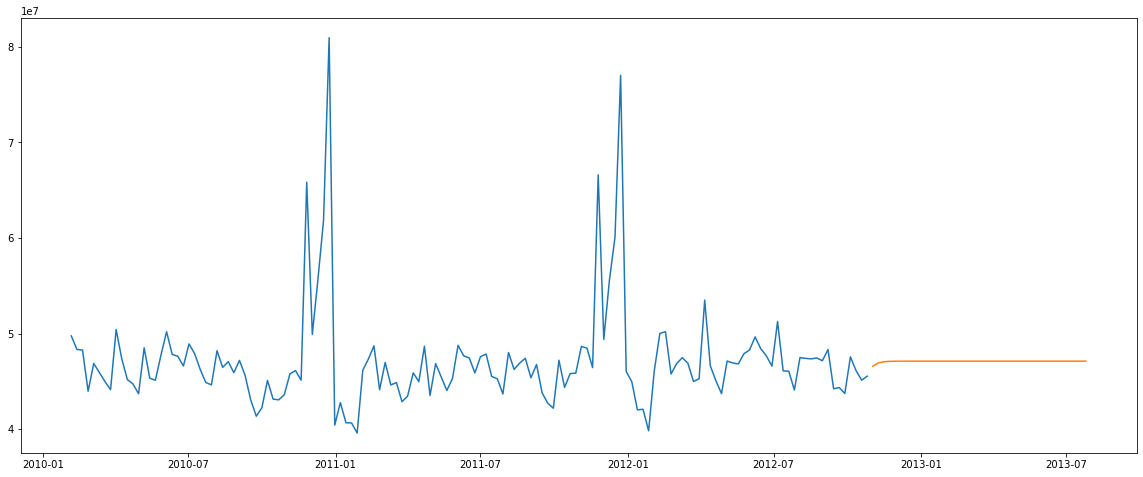

In [101]:
plt.figure(figsize=(20,8))

plt.plot(ts)
plt.plot(df_predictions)